## **EXERCÍCIO 05 - Improving the CNN**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: Tópicos Complementares**
* Professor: **Silvan Ferreira**
* Aluno: **Allan Bispo** - apsb@cesar.school

In [ ]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-07 01:21:05--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  9.62MB/s    in 9.3s    

2024-08-07 01:21:15 (11.2 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
'''# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)'''

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [ ]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

 25%|██▌       | 4/16 [00:00<00:01, 10.97it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 16.65it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 18.24it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 16.27it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.257, Train Accuracy: 16.70%
Epoch 1, Val Loss: 2.113, Val Accuracy: 33.40%


 19%|█▉        | 3/16 [00:00<00:00, 23.44it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 21.68it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 21.24it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.38it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.75it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.862, Train Accuracy: 36.50%
Epoch 2, Val Loss: 1.317, Val Accuracy: 65.80%


 19%|█▉        | 3/16 [00:00<00:00, 22.43it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 22.36it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 22.13it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.52it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 22.16it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.102, Train Accuracy: 63.00%
Epoch 3, Val Loss: 0.737, Val Accuracy: 78.20%


 12%|█▎        | 2/16 [00:00<00:01, 12.72it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 12.50it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 12.55it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 11.82it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 12.54it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 12.70it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 12.67it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.10it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])


100%|██████████| 16/16 [00:01<00:00, 13.03it/s]


Epoch 4, Train Loss: 0.742, Train Accuracy: 75.00%
Epoch 4, Val Loss: 0.604, Val Accuracy: 80.00%


 12%|█▎        | 2/16 [00:00<00:00, 14.62it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 14.66it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 14.71it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.45it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 14.11it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 13.90it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 13.37it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.08it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.547, Train Accuracy: 82.10%
Epoch 5, Val Loss: 0.506, Val Accuracy: 85.00%
Treinamento concluído


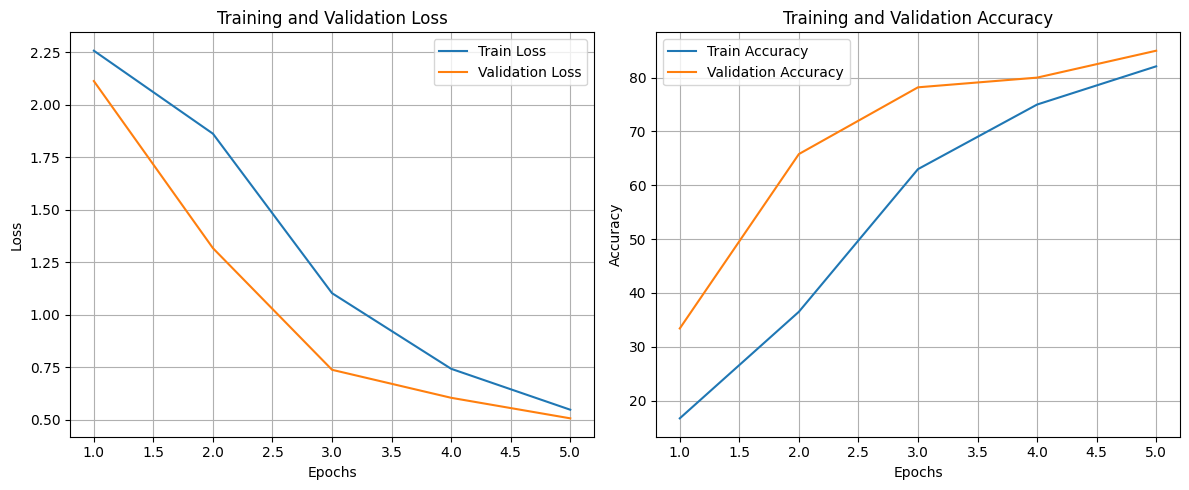

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 84.60%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

`RESPOSTA EXERCÍCIO 1:`
* Aumentar o tamanhos dos filtros ajudou o modelo a capturar mais dados e com isso poder reduzir as perdas e melhorar a acurácia.
* Conforme abaixo, na classe *CNN_ex1*, com mais filtros as perdas ficaram abaixo de 0.50 e a acurácia de treino acima de 90%.
* Com isso, em teste, o modelo passou a apresentar acurácia de 91%, contra 87% do modelo reduzido.

In [ ]:
class CNN_ex1(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN_ex1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model_ex1 = CNN_ex1(
    initialize_weights=True,
    dropout=0.2
)

In [ ]:
criterion_ex1 = nn.CrossEntropyLoss()
optimizer_ex1 = optim.SGD(model_ex1.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history_ex1 = train_model(
    model=model_ex1,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion_ex1,
    optimizer=optimizer_ex1
)

  0%|          | 0/16 [00:00<?, ?it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 12%|█▎        | 2/16 [00:00<00:01, 12.89it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 13.28it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 12.31it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 13.42it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.40it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 14.03it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 13.90it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.294, Train Accuracy: 14.70%


Epoch 1, Val Loss: 2.195, Val Accuracy: 26.80%


 12%|█▎        | 2/16 [00:00<00:01, 11.49it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:01, 11.30it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 11.39it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 12.18it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 13.08it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 12.88it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 12.76it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 12.72it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.980, Train Accuracy: 37.00%


Epoch 2, Val Loss: 1.653, Val Accuracy: 62.60%


  6%|▋         | 1/16 [00:00<00:01,  7.76it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 12%|█▎        | 2/16 [00:00<00:01,  8.13it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:01, 10.31it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 11.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 12.75it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 12.83it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 13.20it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 13.12it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 12.41it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.356, Train Accuracy: 55.50%


Epoch 3, Val Loss: 0.848, Val Accuracy: 74.60%


 12%|█▎        | 2/16 [00:00<00:01, 12.71it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 13.81it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 14.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.30it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 14.78it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.87it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.91it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.799, Train Accuracy: 73.20%


Epoch 4, Val Loss: 0.527, Val Accuracy: 85.00%


 12%|█▎        | 2/16 [00:00<00:00, 14.44it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 14.36it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.79it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.518, Train Accuracy: 83.40%


Epoch 5, Val Loss: 0.401, Val Accuracy: 87.60%
Treinamento concluído


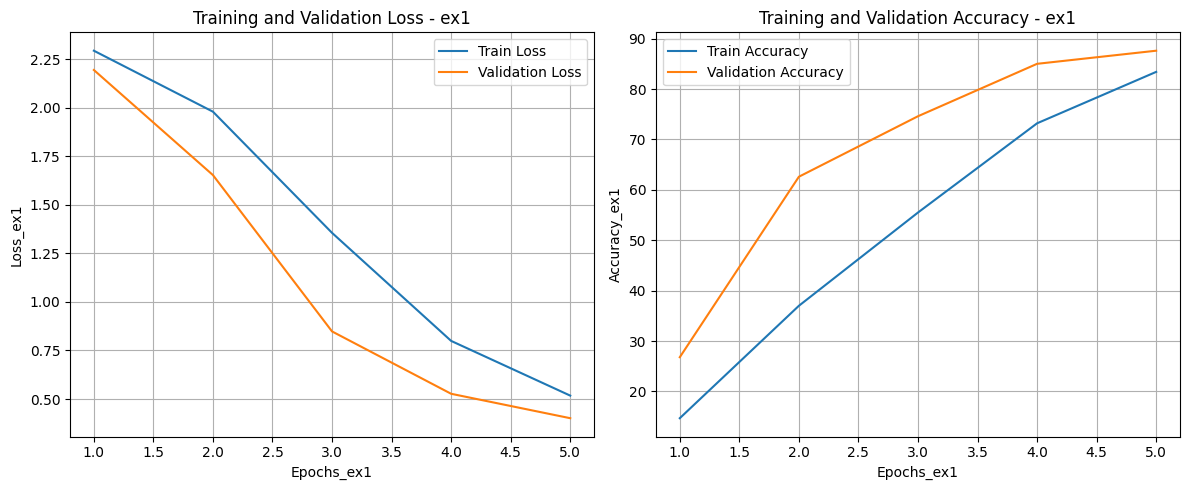

In [ ]:
epochs_ex1 = range(1, len(history_ex1['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs_ex1, history_ex1['train_losses'], label='Train Loss')
plt.plot(epochs_ex1, history_ex1['val_losses'], label='Validation Loss')
plt.xlabel('Epochs_ex1')
plt.ylabel('Loss_ex1')
plt.title('Training and Validation Loss - ex1')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs_ex1, history_ex1['train_accuracies'], label='Train Accuracy')
plt.plot(epochs_ex1, history_ex1['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs_ex1')
plt.ylabel('Accuracy_ex1')
plt.title('Training and Validation Accuracy - ex1')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model_ex1, testloader)

Acurácia da rede na base de teste: 90.20%


**`-------------------xxxxx------------------`**

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

`RESPOSTA EXERCÍCIO 2:`
* Não conseguiria fazer com somente essas informações.
* Com a variação aleatória percebe-se que não há padrão bem definido que relacione o número de neurônios fully connected com a acurácia.
* Há a impressão de haver nos dados mínimos locais espalhados de maneira que a acurácia pode estar boa para num_neurons = 70, mas no próximo loop, com 75 neurônios, a acurácia testada pode dar 4 pontos percentuais mais baixa.

In [ ]:
''' Adaptando a classe CNN_ex1 para atender o solicitado no exercício 2. '''

class CNN_ex2(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN_ex2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
for i in range(10):
    num_neurons = np.random.randint(10, 100)
    model_ex2 = CNN_ex2(initialize_weights=True,dropout=0.2)
    criterion_ex2 = nn.CrossEntropyLoss()
    optimizer_ex2 = optim.SGD(model_ex2.parameters(), lr=0.01, momentum=0.9)
    history_ex2 = train_model(model=model_ex2,trainloader=trainloader,valloader=valloader,criterion=criterion_ex2,optimizer=optimizer_ex2)

    print(f'Número de neurônios na camada fully connected #{i+1}: {num_neurons}')
    test_model(model_ex2, testloader)
    print()

 19%|█▉        | 3/16 [00:00<00:00, 21.81it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 18.57it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 15.99it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 15.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.41it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 14.30it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 15.52it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.278, Train Accuracy: 16.60%


Epoch 1, Val Loss: 2.162, Val Accuracy: 26.20%


 12%|█▎        | 2/16 [00:00<00:00, 15.40it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 14.56it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.65it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 14.99it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.97it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 15.18it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.999, Train Accuracy: 32.10%
Epoch 2, Val Loss: 1.617, Val Accuracy: 54.80%


 12%|█▎        | 2/16 [00:00<00:00, 15.04it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 15.21it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 15.23it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.82it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.328, Train Accuracy: 55.50%
Epoch 3, Val Loss: 0.857, Val Accuracy: 75.20%


 12%|█▎        | 2/16 [00:00<00:00, 15.79it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 15.22it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.58it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 13.93it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 13.54it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 12.83it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 13.98it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.840, Train Accuracy: 71.30%
Epoch 4, Val Loss: 0.667, Val Accuracy: 77.80%


 12%|█▎        | 2/16 [00:00<00:00, 14.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 13.95it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.58it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 13.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.36it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])


100%|██████████| 16/16 [00:01<00:00, 14.07it/s]


Epoch 5, Train Loss: 0.648, Train Accuracy: 77.30%
Epoch 5, Val Loss: 0.517, Val Accuracy: 84.60%
Treinamento concluído
Número de neurônios na camada fully connected #1: 55
Acurácia da rede na base de teste: 86.60%



 12%|█▎        | 2/16 [00:00<00:00, 15.33it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 14.32it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 13.70it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 13.70it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 13.39it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 13.65it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 12.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 13.37it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.229, Train Accuracy: 19.60%
Epoch 1, Val Loss: 2.017, Val Accuracy: 42.80%


 12%|█▎        | 2/16 [00:00<00:01, 12.75it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 12.91it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 12.79it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 11.60it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.39it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.43it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.639, Train Accuracy: 48.60%


Epoch 2, Val Loss: 1.127, Val Accuracy: 63.80%


 12%|█▎        | 2/16 [00:00<00:00, 18.03it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 16.30it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 16.87it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 17.07it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 16.92it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 17.01it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 17.39it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 17.48it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 0.947, Train Accuracy: 68.10%


Epoch 3, Val Loss: 0.592, Val Accuracy: 84.00%


 12%|█▎        | 2/16 [00:00<00:00, 17.56it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 17.13it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 17.19it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 16.94it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 16.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 16.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 17.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 17.28it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.534, Train Accuracy: 84.10%


Epoch 4, Val Loss: 0.408, Val Accuracy: 87.60%


 12%|█▎        | 2/16 [00:00<00:00, 17.84it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 17.18it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 17.12it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 17.26it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 17.20it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 16.88it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 16.51it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 17.23it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.378, Train Accuracy: 86.90%


Epoch 5, Val Loss: 0.351, Val Accuracy: 89.00%
Treinamento concluído
Número de neurônios na camada fully connected #2: 78
Acurácia da rede na base de teste: 89.60%



 12%|█▎        | 2/16 [00:00<00:00, 17.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 17.11it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 17.19it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 17.01it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 17.04it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 17.11it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 17.30it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 17.57it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.260, Train Accuracy: 19.00%


Epoch 1, Val Loss: 2.154, Val Accuracy: 41.00%


 12%|█▎        | 2/16 [00:00<00:00, 16.59it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 16.31it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 16.79it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 16.55it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 16.70it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 16.36it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 16.29it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 16.71it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.980, Train Accuracy: 37.90%


Epoch 2, Val Loss: 1.644, Val Accuracy: 55.00%


 12%|█▎        | 2/16 [00:00<00:00, 19.29it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 31%|███▏      | 5/16 [00:00<00:00, 21.12it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 21.43it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 21.43it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 20.92it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.36it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.328, Train Accuracy: 56.60%
Epoch 3, Val Loss: 0.825, Val Accuracy: 77.20%


 12%|█▎        | 2/16 [00:00<00:00, 19.29it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 21.32it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 20.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.24it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.734, Train Accuracy: 75.50%
Epoch 4, Val Loss: 0.583, Val Accuracy: 82.80%


 19%|█▉        | 3/16 [00:00<00:00, 21.08it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 20.32it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 17.07it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 15.51it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 81%|████████▏ | 13/16 [00:00<00:00, 15.60it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 15.88it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 16.79it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.522, Train Accuracy: 82.20%
Epoch 5, Val Loss: 0.469, Val Accuracy: 85.40%
Treinamento concluído
Número de neurônios na camada fully connected #3: 90
Acurácia da rede na base de teste: 88.20%



 12%|█▎        | 2/16 [00:00<00:00, 15.16it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs:

 25%|██▌       | 4/16 [00:00<00:00, 14.05it/s]

 torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 14.71it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.68it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 14.63it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 14.33it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 14.30it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.49it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.265, Train Accuracy: 19.80%


Epoch 1, Val Loss: 2.131, Val Accuracy: 39.40%


 12%|█▎        | 2/16 [00:00<00:01, 13.89it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 13.43it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 13.59it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 13.68it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 81%|████████▏ | 13/16 [00:00<00:00, 17.15it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 16.74it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.877, Train Accuracy: 42.50%


Epoch 2, Val Loss: 1.527, Val Accuracy: 51.00%


 19%|█▉        | 3/16 [00:00<00:00, 23.16it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 21.75it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.82it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.29it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.77it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.214, Train Accuracy: 61.70%
Epoch 3, Val Loss: 0.781, Val Accuracy: 73.40%


 19%|█▉        | 3/16 [00:00<00:00, 22.73it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 21.46it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.05it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.93it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.729, Train Accuracy: 75.70%
Epoch 4, Val Loss: 0.545, Val Accuracy: 83.80%


 19%|█▉        | 3/16 [00:00<00:00, 22.12it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 20.79it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.58it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.519, Train Accuracy: 82.70%
Epoch 5, Val Loss: 0.492, Val Accuracy: 85.20%
Treinamento concluído
Número de neurônios na camada fully connected #4: 61
Acurácia da rede na base de teste: 86.40%



 19%|█▉        | 3/16 [00:00<00:00, 21.06it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 21.44it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.99it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.43it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.56it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.282, Train Accuracy: 14.40%
Epoch 1, Val Loss: 2.205, Val Accuracy: 25.20%


 12%|█▎        | 2/16 [00:00<00:00, 18.55it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 21.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 21.62it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.29it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 2.110, Train Accuracy: 25.60%
Epoch 2, Val Loss: 1.951, Val Accuracy: 32.60%


 12%|█▎        | 2/16 [00:00<00:00, 18.73it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 31%|███▏      | 5/16 [00:00<00:00, 20.83it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 21.24it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 21.54it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.30it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.813, Train Accuracy: 35.80%
Epoch 3, Val Loss: 1.409, Val Accuracy: 64.40%


 19%|█▉        | 3/16 [00:00<00:00, 23.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 21.48it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 21.07it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 20.93it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.46it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 1.306, Train Accuracy: 58.00%
Epoch 4, Val Loss: 0.926, Val Accuracy: 75.00%


 19%|█▉        | 3/16 [00:00<00:00, 22.54it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 21.37it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 21.13it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.52it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.50it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 1.040, Train Accuracy: 63.80%
Epoch 5, Val Loss: 0.666, Val Accuracy: 82.20%
Treinamento concluído
Número de neurônios na camada fully connected #5: 20
Acurácia da rede na base de teste: 83.40%



 19%|█▉        | 3/16 [00:00<00:00, 21.40it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 20.99it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 19.02it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 16.59it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 81%|████████▏ | 13/16 [00:00<00:00, 15.57it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 17.12it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.252, Train Accuracy: 16.50%


Epoch 1, Val Loss: 2.065, Val Accuracy: 32.80%


 12%|█▎        | 2/16 [00:00<00:00, 17.72it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 16.65it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 16.07it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 16.37it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 16.01it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 15.21it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 15.74it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.841, Train Accuracy: 36.10%
Epoch 2, Val Loss: 1.472, Val Accuracy: 52.60%


 12%|█▎        | 2/16 [00:00<00:00, 14.85it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 14.46it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.64it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 13.83it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 13.79it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: 

100%|██████████| 16/16 [00:01<00:00, 14.15it/s]


torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.279, Train Accuracy: 54.90%
Epoch 3, Val Loss: 0.924, Val Accuracy: 65.80%


 19%|█▉        | 3/16 [00:00<00:00, 21.39it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.22it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 19.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.75it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.846, Train Accuracy: 72.20%
Epoch 4, Val Loss: 0.557, Val Accuracy: 82.20%


 19%|█▉        | 3/16 [00:00<00:00, 20.84it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.93it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 19.36it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.585, Train Accuracy: 81.00%
Epoch 5, Val Loss: 0.429, Val Accuracy: 87.80%
Treinamento concluído
Número de neurônios na camada fully connected #6: 31
Acurácia da rede na base de teste: 89.00%



 19%|█▉        | 3/16 [00:00<00:00, 22.31it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 21.00it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.21it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.09it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.306, Train Accuracy: 13.50%
Epoch 1, Val Loss: 2.246, Val Accuracy: 23.60%


 19%|█▉        | 3/16 [00:00<00:00, 19.80it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.99it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.87it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.54it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 2.135, Train Accuracy: 31.30%


Epoch 2, Val Loss: 1.944, Val Accuracy: 41.00%


 12%|█▎        | 2/16 [00:00<00:00, 18.55it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 21.02it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 20.97it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.78it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.612, Train Accuracy: 47.40%
Epoch 3, Val Loss: 1.016, Val Accuracy: 72.60%


 12%|█▎        | 2/16 [00:00<00:00, 19.08it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 31%|███▏      | 5/16 [00:00<00:00, 20.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 20.93it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 20.81it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 20.10it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.85it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.930, Train Accuracy: 71.00%


Epoch 4, Val Loss: 0.534, Val Accuracy: 83.40%


 12%|█▎        | 2/16 [00:00<00:00, 19.91it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 31%|███▏      | 5/16 [00:00<00:00, 20.57it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 20.60it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 19.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])

 88%|████████▊ | 14/16 [00:00<00:00, 20.37it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.63it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.597, Train Accuracy: 80.60%


Epoch 5, Val Loss: 0.444, Val Accuracy: 85.40%
Treinamento concluído
Número de neurônios na camada fully connected #7: 56
Acurácia da rede na base de teste: 84.00%



 19%|█▉        | 3/16 [00:00<00:00, 19.74it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 20.64it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 20.91it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.68it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.258, Train Accuracy: 19.50%
Epoch 1, Val Loss: 2.114, Val Accuracy: 33.40%


 12%|█▎        | 2/16 [00:00<00:00, 17.94it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 20.51it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 20.23it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 19.18it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.800, Train Accuracy: 45.20%


Epoch 2, Val Loss: 1.279, Val Accuracy: 65.40%


 12%|█▎        | 2/16 [00:00<00:00, 16.65it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 15.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 15.94it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 15.76it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 15.97it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 15.11it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 15.85it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 0.957, Train Accuracy: 69.10%


Epoch 3, Val Loss: 0.714, Val Accuracy: 75.00%


 12%|█▎        | 2/16 [00:00<00:00, 14.20it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 14.52it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 12.61it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 13.71it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:01<00:00, 13.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 12.98it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.560, Train Accuracy: 82.40%
Epoch 4, Val Loss: 0.432, Val Accuracy: 88.00%


 12%|█▎        | 2/16 [00:00<00:00, 14.92it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 17.19it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 44%|████▍     | 7/16 [00:00<00:00, 19.27it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 81%|████████▏ | 13/16 [00:00<00:00, 20.42it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 19.81it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.379, Train Accuracy: 89.00%
Epoch 5, Val Loss: 0.377, Val Accuracy: 86.20%
Treinamento concluído
Número de neurônios na camada fully connected #8: 98
Acurácia da rede na base de teste: 92.20%



 19%|█▉        | 3/16 [00:00<00:00, 21.85it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.69it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.74it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 21.05it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.225, Train Accuracy: 19.90%
Epoch 1, Val Loss: 2.041, Val Accuracy: 37.80%


 19%|█▉        | 3/16 [00:00<00:00, 22.51it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 20.84it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.59it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.92it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 20.80it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 21.14it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.840, Train Accuracy: 36.40%
Epoch 2, Val Loss: 1.394, Val Accuracy: 60.60%


 19%|█▉        | 3/16 [00:00<00:00, 22.46it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 19.37it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.21it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.34it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:00<00:00, 20.78it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.85it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 1.294, Train Accuracy: 54.30%
Epoch 3, Val Loss: 0.901, Val Accuracy: 71.60%


 19%|█▉        | 3/16 [00:00<00:00, 20.55it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 56%|█████▋    | 9/16 [00:00<00:00, 20.32it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 20.62it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.63it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 4, Train Loss: 0.895, Train Accuracy: 68.20%
Epoch 4, Val Loss: 0.581, Val Accuracy: 81.20%


 12%|█▎        | 2/16 [00:00<00:00, 19.56it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 19.18it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 44%|████▍     | 7/16 [00:00<00:00, 16.54it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 69%|██████▉   | 11/16 [00:00<00:00, 10.02it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 13.21it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.741, Train Accuracy: 75.10%


Epoch 5, Val Loss: 0.479, Val Accuracy: 84.20%
Treinamento concluído
Número de neurônios na camada fully connected #9: 22
Acurácia da rede na base de teste: 85.00%



 12%|█▎        | 2/16 [00:00<00:00, 19.66it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 31%|███▏      | 5/16 [00:00<00:00, 20.99it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 16.37it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 94%|█████████▍| 15/16 [00:01<00:00, 13.33it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 13.45it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 1, Train Loss: 2.230, Train Accuracy: 18.40%
Epoch 1, Val Loss: 2.058, Val Accuracy: 39.00%


 19%|█▉        | 3/16 [00:00<00:00, 20.86it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 20.61it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 19.98it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 20.72it/s]


Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 2, Train Loss: 1.720, Train Accuracy: 44.70%
Epoch 2, Val Loss: 1.196, Val Accuracy: 64.60%


 12%|█▎        | 2/16 [00:00<00:00, 17.19it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 15.76it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 15.68it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 15.91it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 75%|███████▌  | 12/16 [00:00<00:00, 16.01it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 88%|████████▊ | 14/16 [00:00<00:00, 15.83it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 16.09it/s]

Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 3, Train Loss: 0.959, Train Accuracy: 69.00%


Epoch 3, Val Loss: 0.647, Val Accuracy: 79.20%


 12%|█▎        | 2/16 [00:00<00:00, 14.14it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 14.50it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 14.90it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])

 75%|███████▌  | 12/16 [00:00<00:00, 14.54it/s]


Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:01<00:00, 14.83it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])


100%|██████████| 16/16 [00:01<00:00, 14.49it/s]


Epoch 4, Train Loss: 0.535, Train Accuracy: 81.70%
Epoch 4, Val Loss: 0.457, Val Accuracy: 86.80%


 12%|█▎        | 2/16 [00:00<00:00, 14.36it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 25%|██▌       | 4/16 [00:00<00:00, 14.04it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 38%|███▊      | 6/16 [00:00<00:00, 13.68it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 50%|█████     | 8/16 [00:00<00:00, 13.75it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 62%|██████▎   | 10/16 [00:00<00:00, 15.33it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


 81%|████████▏ | 13/16 [00:00<00:00, 17.42it/s]

Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])
Shape of outputs: torch.Size([64, 10])
Shape of labels: torch.Size([64])


100%|██████████| 16/16 [00:00<00:00, 16.56it/s]


Shape of outputs: torch.Size([40, 10])
Shape of labels: torch.Size([40])
Epoch 5, Train Loss: 0.403, Train Accuracy: 86.90%
Epoch 5, Val Loss: 0.428, Val Accuracy: 86.00%
Treinamento concluído
Número de neurônios na camada fully connected #10: 54
Acurácia da rede na base de teste: 90.60%

